# 例一：全连接网络

Sequential 模型可能是实现这种网络的一个更好选择，但这个例子能够帮助我们进行一些简单的理解。

网络层的实例是可调用的，它以张量为参数，并且返回一个张量

输入和输出均为张量，它们都可以用来定义一个模型（Model）

这样的模型同 Keras 的 Sequential 模型一样，都可以被训练

In [ ]:
from keras.layers import Input,Dense
from keras.models import Model

#这部分返回一个张量
inputs=Inputs(shape=(784,))

#层的实例是可调用的，它以张量为参数，并且返回一个张量
x=Dense(64,activation='relu')(inputs)
x=Dense(64,activation='relu')(x)
predictions=Dense(10,activation='softmax')(x)

#这部分创建一个包含输入层和三个全连接层的模型
model=Model(inputs=inputs,outputs=predictions)
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(data,labels)#开始训练

# 所有的模型都可调用，就像网络层一样

利用函数式 API，可以轻易地重用训练好的模型：可以将任何模型看作是一个层，然后通过传递一个张量来调用它。注意，在调用模型时，您不仅重用模型的结构，还重用了它的权重。

In [ ]:
x=Input(shape=(784,))
# 这是可行的，并且返回上面定义的 10-way softmax。
y=model(x)

这种方式能允许我们快速创建可以处理序列输入的模型。只需一行代码，你就将图像分类模型转换为视频分类模型。

In [ ]:
from keras.layers import TimeDistributed

# 输入张量是 20 个时间步的序列，每一个时间为一个 784 维的向量
input_sequences=Input(shape=(20,784))

# 这部分将我们之前定义的模型应用于输入序列中的每个时间步。
# 之前定义的模型的输出是一个 10-way softmax，
# 因而下面的层的输出将是维度为 10 的 20 个向量的序列。
processed_sequences=TimeDistributed(model)(input_sequences)

# 多输入多输出模型

以下是函数式 API 的一个很好的例子：具有多个输入和输出的模型。函数式 API 使处理大量交织的数据流变得容易。

来考虑下面的模型。我们试图预测 Twitter 上的一条新闻标题有多少转发和点赞数。模型的主要输入将是新闻标题本身，即一系列词语，但是为了增添趣味，我们的模型还添加了其他的辅助输入来接收额外的数据，例如新闻标题的发布的时间等。 该模型也将通过两个损失函数进行监督学习。较早地在模型中使用主损失函数，是深度学习模型的一个良好正则方法。

模型结构如下图所示：
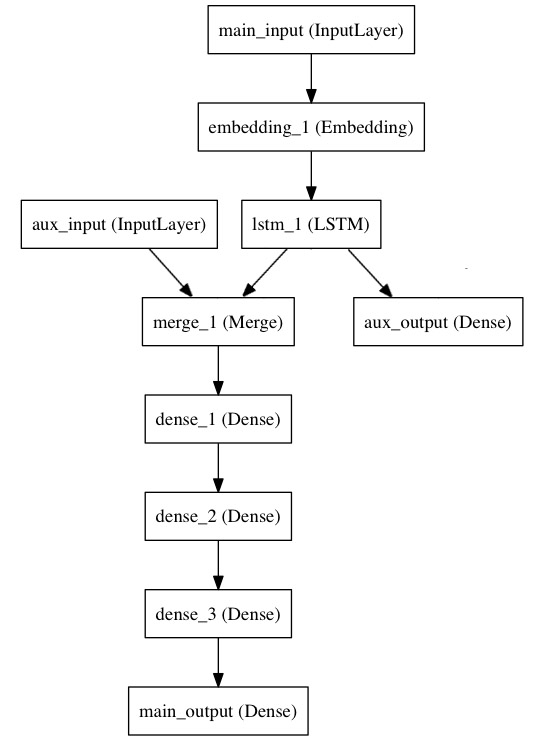

主要输入接收新闻标题本身，即一个整数序列（每个整数编码一个词）。 这些整数在 1 到 10,000 之间（10,000 个词的词汇表），且序列长度为 100 个词。

In [3]:
from keras.layers import Input,Embedding,LSTM,Dense
from keras.models import Model

#标题输入：接受一个含有100个整数的序列，每个整数在1到10000之间。
#注意我们可以通过传递一个‘name’参数来命名任何层。
main_input=Input(shape=(100,),dtype='int32',name='mian_input')

#Embedding层将输入序列编码为一个稠密向量的序列，每个向量维度为512。
x=Embedding(output_dim=512,input_dim=10000,input_length=100)(main_input)

#LSTM层把向量序列转换成单个向量，它包含整个序列的上下文信息
lstm_out=LSTM(32)(x)

在这里，我们插入辅助损失，使得即使在模型主损失很高的情况下，LSTM 层和 Embedding 层都能被平稳地训练。

In [ ]:
auxiliary_output=Dense(1,activation='sigmoid',name='aux_output')(lstm_out)

此时，我们将辅助输入数据与 LSTM 层的输出连接起来，输入到模型中

In [ ]:
auxiliary_input=Input(shape=(5,),name='aux_input')
x=keras.layers.concatenate([lstm_out,auxiliary_input])

#堆叠多个全连接网络层
x=Dense(64,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x=Dense(64,activation='relu')(x)

#最后添加主要的逻辑回归层
main_output=Dense(1,activation='sigmoid',name='main_output')(x)

然后定义一个具有两个输入和两个输出的模型

In [ ]:
model=Model(inputs=[main_input,auxiliary_input],outputs=[main_output,auxiliary_output])

现在编译模型，并给辅助损失分配一个 0.2 的权重。如果要为不同的输出指定不同的  loss_weights 或 loss，可以使用列表或字典。 在这里，我们给 loss 参数传递单个损失函数，这个损失将用于所有的输出。

In [ ]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',
             loss_weights=[1.,0.2])

我们可以通过传递输入数组和目标数组的列表来训练模型

In [ ]:
model.fit([headline_data,additional_data],[labels,labels],
         epochs=50,batch_size=32)

由于输入和输出均被命名了（在定义时传递了一个 name 参数），我们也可以通过以下方式编译模型

In [ ]:
model.compile(optimizer='rmsprop',
             loss={'main_output':'binary_crossentropy','aux_output':'binary_crossentropy'},
             loss_weights={'main_output':1.,'aux_output':0.2})

#r然后使用以下方式训练：
model.fit({'main_input':headline_data,'aux_input':additional_data},
         {'main_output':labels,'aux_output':labels},
         epochs=50,batch_size=32)

# 共享网络层

函数式 API 的另一个用途是使用共享网络层的模型。我们来看看共享层。

来考虑推特推文数据集。我们想要建立一个模型来分辨两条推文是否来自同一个人（例如，通过推文的相似性来对用户进行比较）。

实现这个目标的一种方法是建立一个模型，将两条推文编码成两个向量，连接向量，然后添加逻辑回归层；这将输出两条推文来自同一作者的概率。模型将接收一对对正负表示的推特数据。

由于这个问题是对称的，编码第一条推文的机制应该被完全重用来编码第二条推文。这里我们使用一个共享的 LSTM 层来编码推文。

让我们使用函数式 API 来构建它。首先我们将一条推特转换为一个尺寸为 (140, 256) 的矩阵，即每条推特 140 字符，每个字符为 256 维的 one-hot 编码 （取 256 个常用字符）。

In [ ]:
import keras
from keras.layers import Input,LSTM,Dense
from keras.models import Model

tweet_a=Input(shape=(140,256))
tweet_b=Input(shape=(140,256))

要在不同的输入上共享同一个层，只需实例化该层一次，然后根据需要传入你想要的输入即可：

In [ ]:
# 这一层可以输入一个矩阵，并返回一个 64 维的向量
shared_lstm=LSTM(64)

# 当我们重用相同的图层实例多次，图层的权重也会被重用 (它其实就是同一层)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)

# 然后再连接两个向量
merged_vector=keras.layers.concatenate([encoded_a,encoded_b],axis=-1)

# 再在上面添加一个逻辑回归层
predictions=Dense(1,activation='sigmoid')(merged_vector)

# 定义一个连接推特输入和预测的可训练的模型
model=Model(inputs=[tweet_a,tweet_b],outputs=predictions)

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.fit([data_a,data_b],labels,epochs=10)

让我们暂停一会，看看如何读取共享层的输出或输出尺寸。

# 层「节点」的概念

每当你在某个输入上调用一个层时，都将创建一个新的张量（层的输出），并且为该层添加一个「节点」，将输入张量连接到输出张量。当多次调用同一个图层时，该图层将拥有多个节点索引 (0, 1, 2...)。

在之前版本的 Keras 中，可以通过 layer.get_output() 来获得层实例的输出张量，或者通过 layer.output_shape 来获取其输出形状。现在你依然可以这么做（除了  get_output() 已经被 output 属性替代）。但是如果一个层与多个输入连接呢？

只要一个层只连接到一个输入，就不会有困惑，.output 会返回层的唯一输出：

In [ ]:
a=Input(shape=(140,256))

lstm=LSTM(32)
encoded_a=lstm(a)

assert lstm.output==encoded_a

但是如果该层有多个输入，那就会出现问题：

In [ ]:
a=Input(shape=(140,256))
b=Input(shape=(140,256))

lstm=LSTM(32)
encoded_a=lstm(a)
encoded_b=lstm(b)

lstm.output

>> AttributeError: Layer lstm_1 has multiple inbound nodes,
hence the notion of "layer output" is ill-defined.
Use `get_output_at(node_index)` instead.

好吧，通过下面的方法可以解决：

In [ ]:
assert lstm.get_output_at(0)==encoded_a
assert lstm.get_output_at(1)==encoded_b

input_shape 和 output_shape 这两个属性也是如此：只要该层只有一个节点，或者只要所有节点具有相同的输入/输出尺寸，那么「层输出/输入尺寸」的概念就被很好地定义，并且将由 layer.output_shape / layer.input_shape 返回。但是比如说，如果将一个 Conv2D 层先应用于尺寸为 (32，32，3) 的输入，再应用于尺寸为  (64, 64, 3) 的输入，那么这个层就会有多个输入/输出尺寸，你将不得不通过指定它们所属节点的索引来获取它们：

In [ ]:
a=Input(shape=(32,32,3))
b=Input(shape=(64,64,3))

conv=Conv2D(16,(3,3),padding='same')
conved_a=conv(a)

# 到目前为止只有一个输入，以下可行：
assert conv.input_shape==(None,32,32,3)

conved_b=conv(b)
# 现在 `.input_shape` 属性不可行，但是这样可以：
assert conv.get_input_shape_at(0)==(None,32,32,3)
assert conv.get_input_shape_at(1)==(None,64,64,3)

# Inception 模型

In [ ]:
from keras.layers import Conv2D,MaxPooling2D,Input

input_img=Input(shape=(256,256,3))

tower_1=Conv2D(64,(1,1),padding='same',activation='relu')(input_img)
tower_1=Conv2D(64,(3,3),padding='same',activation='relu')(tower_1)

tower_2=Conv2D(64,(1,1),padding='same',activation='relu')(input_img)
tower_2=Conv2D(64,(5,5),padding='same',activation='relu')(tower_2)

tower_3=MaxPooling2D((3,3),strides=(1,1),padding='same')(input_img)
tower_3=Conv2D(64,(1,1),padding='same',activation='relu')(tower_3)

output=keras.layers.concatenate([tower_1,tower_2,tower_3],axis=1)

# 卷积层上的残差连接

In [ ]:
from keras.layers import Conv2D,Input

# 输入张量为 3 通道 256x256 图像
x=Input(shape=(256,256,3))
# 3 输出通道（与输入通道相同）的 3x3 卷积核
y=conv2D(3,(3,3),padding='same')(x)
# 返回 x + y
z=keras.layers.add([x,y])

# 共享视觉模型

该模型在两个输入上重复使用同一个图像处理模块，以判断两个 MNIST 数字是否为相同的数字。

In [ ]:
from keras.layers import Conv2D,MaxPooling2D,Input,Dense,Flatten
from keras.models import Model

#首先，定义视觉模型
digit_input=Input(shape=(27,27,1))
x=Conv2D(64,(3,3))(digit_input)
x=Conv2D(64,(3,3))(x)
x=MaxPooling2D((2,2))(x)
out=Flatten()(x)

vision_model=Model(digit_input,out)

# 然后，定义区分数字的模型
digit_a=Input(shape=(27,27,1))
digit_b=Input(shape=(27,27,1))

# 视觉模型将被共享，包括权重和其他所有
out_a=vision_model(digit_a)
out_b=vision_model(digit_b)

concatenated=keras.layers.concatenate([out_a,out_b])
out=Dense(1,activation='sigmoid')(concatented)

classification_model=Model([digit_a,digit_b],out)

# 视觉问答模型

当被问及关于图片的自然语言问题时，该模型可以选择正确的单词作答。

它通过将问题和图像编码成向量，然后连接两者，在上面训练一个逻辑回归，来从词汇表中挑选一个可能的单词作答。

In [ ]:
from keras.layers import Conv2D,MaxPooling2D,Flatten
from keras.layers import Input,LSTM,Embedding,Dense
from keras.models import Model,Sequential

# 首先，让我们用 Sequential 来定义一个视觉模型。
# 这个模型会把一张图像编码为向量。
vision_model=Sequential()
vision_model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(224,224,3)))
vision_model.add(Conv2D(64,(3,3),activation='relu'))
vision_model.add(MaxPooling2D((2,2)))
vision_model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
vision_model.add(Conv2D(128,(3,3),activation='relu'))
vision_model.add(MaxPooling2D((2,2)))
vision_model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
vision_model.add(Conv2D(256,(3,3),activation='relu'))
vision_model.add(Conv2D(256,(3,3),activation='relu'))
vision_model.add(MaxPooling2D((2,2)))
vision_model.add(Flatten())

# 现在让我们用视觉模型来得到一个输出张量
image_input=Input(shape=(224,224,3))
encoded_image=vision_model(image_input)

# 接下来，定义一个语言模型来将问题编码成一个向量。
# 每个问题最长 100 个词，词的索引从 1 到 9999.
question_input=Input(shape=(100,),dtype='int32')
embedded_question=Embedding(input_dim=10000,output_dim=256,input_length=100)(question_input)
encoded_question=LSTM(256)(embedded_question)

# 连接问题向量和图像向量：
merged=keras.layers.concatenate([encoded_question,encoded_image])

# 然后在上面训练一个 1000 词的逻辑回归模型：
output=Dense(1000,activation='softmax')(merged)

# 最终模型：
vqa_model=Model(inputs=[image_input,qyestion_input],outputs=output)

# 下一步就是在真实数据上训练模型。

# 视频问答模型

现在我们已经训练了图像问答模型，我们可以很快地将它转换为视频问答模型。在适当的训练下，你可以给它展示一小段视频（例如 100 帧的人体动作），然后问它一个关于这段视频的问题（例如，「这个人在做什么运动？」 -> 「足球」）。

In [ ]:
from keras.layers import TimeDistributed

video_input=Input(shape=(100,224,224,3))
# 这是基于之前定义的视觉模型（权重被重用）构建的视频编码
encoded_frame_sequence=TimeDistribted(vision_model)(video_input)# 输出为向量的序列
encoded_video=LSTM(256)(encoded_frame_sequence) # 输出为一个向量

# 这是问题编码器的模型级表示，重复使用与之前相同的权重：
question_encoder=Model(inputs=question_input,outputs=encoded_question)

#让我们来编码这个问题：
video_question_input=Input(shape=(100,),dtype='int32')
encoded_video_question=question_encoder(video_question_input)

# 这就是我们的视频问答模式：
merged=keras.layers.concatenate([encoded_video,encoded_video_question])
output=Dense(1000,activation='softmax')(merged)
video_qa_model=Model(inputs=[video_input,video_question_input],outputs=output)